In [ ]:
#Installing required libraries

!pip install -q transformers pandas numpy bs4 matplotlib wordcloud
!pip install -q gspread oauth2client

Installing Selenium in Colab Environment

In [ ]:
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb

wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/118.0.5993.70/linux64/chromedriver-linux64.zip -P /tmp/
unzip -o /tmp/chromedriver-linux64.zip -d /tmp/
chmod +x /tmp/chromedriver-linux64/chromedriver
mv /tmp/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver
pip install selenium chromedriver_autoinstaller

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy/main Sources [2,264 kB]
Get:12 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy/main amd64 Packages [1,162 kB]
Fetched 3,676 kB in 4s (

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options as ChromeOptions
import chromedriver_autoinstaller

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chromedriver_autoinstaller.install()

driver = webdriver.Chrome(options=chrome_options)

Website 1 - https://www.cnbc.com/search/?query=green%20hydrogen&qsearchterm=green%20hydrogen  
Since it is a dynamic page, I've used selenium.  
The scroll height of the website is obtained and with that, I've scrolled to the end of the page to load all visible elements.  

XPath Selectors are used to extract title, date and link of the article.
The date is further extracted using a regex expression  

In [ ]:
from datetime import datetime
import pandas as pd
import time
import re

url1 = 'https://www.cnbc.com/search/?query=green%20hydrogen&qsearchterm=green%20hydrogen'

driver.get(url1)
SCROLL_PAUSE_TIME = 2

last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

wait = WebDriverWait(driver, 10)
titles = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//span[@class="Card-title"]')))
dates = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//span[@class="SearchResult-publishedDate"]')))
# <div class="SearchResult-searchResultTitle"><a class="resultlink" style="color:black;" href="https://www.cnbc.com/video/2024/01/29/acwa-power-to-develop-green-hydrogen-project-in-indonesia.html?&amp;qsearchterm=green hydrogen"><span class="Card-title">Saudi Arabia’s ACWA Power to develop largest <span style="background-color: #e7ecf1">green</span> <span style="background-color: #e7ecf1">hydrogen</span> project in Indonesia worth over $1 ...</span></a></div>
links = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//div[@class="SearchResult-searchResultTitle"]/a[@class="resultlink"]')))

pattern=r'\d{1,2}\/\d{1,2}\/\d{4}'
titles=[i.text for i in titles]
dates=[re.search(pattern,i.text)[0] for i in dates]
links=[i.get_attribute('href') for i in links]

Website 2 - https://news.google.com/rss/search?q=green%20hydrogen&hl=en-IN&gl=IN&ceid=IN:en  
Since it is a static page, it is much simpler to go with BeautifulSoup.  
Title, date and link are extracted and date is filtered through the regex expression  

In [ ]:
from bs4 import BeautifulSoup
import requests
import numpy as np

url2 = "https://news.google.com/rss/search?q=green%20hydrogen&hl=en-IN&gl=IN&ceid=IN:en"
site=requests.get(url2)

soup=BeautifulSoup(site.content,'lxml')
items = soup.find_all('item')

pattern=r'\d{1,2} \w{3} \d{4}'

dates2 = []

for item in items:
    titles.append(item.find('title').text)

    date=str(item.find('pubdate'))
    date=re.search(pattern,date)[0]
    dates2.append(date)

    link=item.find('description').text
    link=re.split(r'\"',link)[1]
    links.append(link)

/usr/local/lib/python3.10/dist-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


The two date arrays are of different formats. To make them uniform, I have


*   Converted both arrays to Pandas datetime64 datatype
*   Then converted both array formats to a lists of the same format
*   Merged both lists into a single one
*   Converted final list back to Pandas datetime64 datatype so that it can be used for the graph.







In [ ]:
dates=pd.to_datetime(dates, format="%m/%d/%Y")
dates2=pd.to_datetime(dates2, format="%d %b %Y")
new2= list(dates2.strftime('%m-%d-%Y'))
new=list(dates.strftime('%m-%d-%Y'))
new.extend(new2)
final_dates=pd.to_datetime(new, format="%m-%d-%Y")

#### Sentiment Analysis  
Stored the label and the score in separate arrays.

In [ ]:
from transformers import pipeline
model_name='cardiffnlp/twitter-roberta-base-sentiment-latest'
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

sentiments=sentiment_pipeline(titles)
labels=[i['label'] for i in sentiments]
scores=[i['score'] for i in sentiments]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT 

#### Named Entity Recognition

df.apply was told to be used but the pipeline supports arrays as a parameter, so I've used that as it is simpler.

In [ ]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

res = ner_pipeline(titles)
organizations = [[entity['word'] for entity in i if 'ORG' in entity['entity_group']] for i in res]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


Creating the dataframe using all obtained arrays

In [ ]:
import pandas as pd
df=pd.DataFrame({
    "Title":titles,
    "Date":final_dates,
    "Source":links,
    "Label":labels,
    "Score":scores,
    "Organizations":organizations
})

#### Word Cloud map of Organization Names

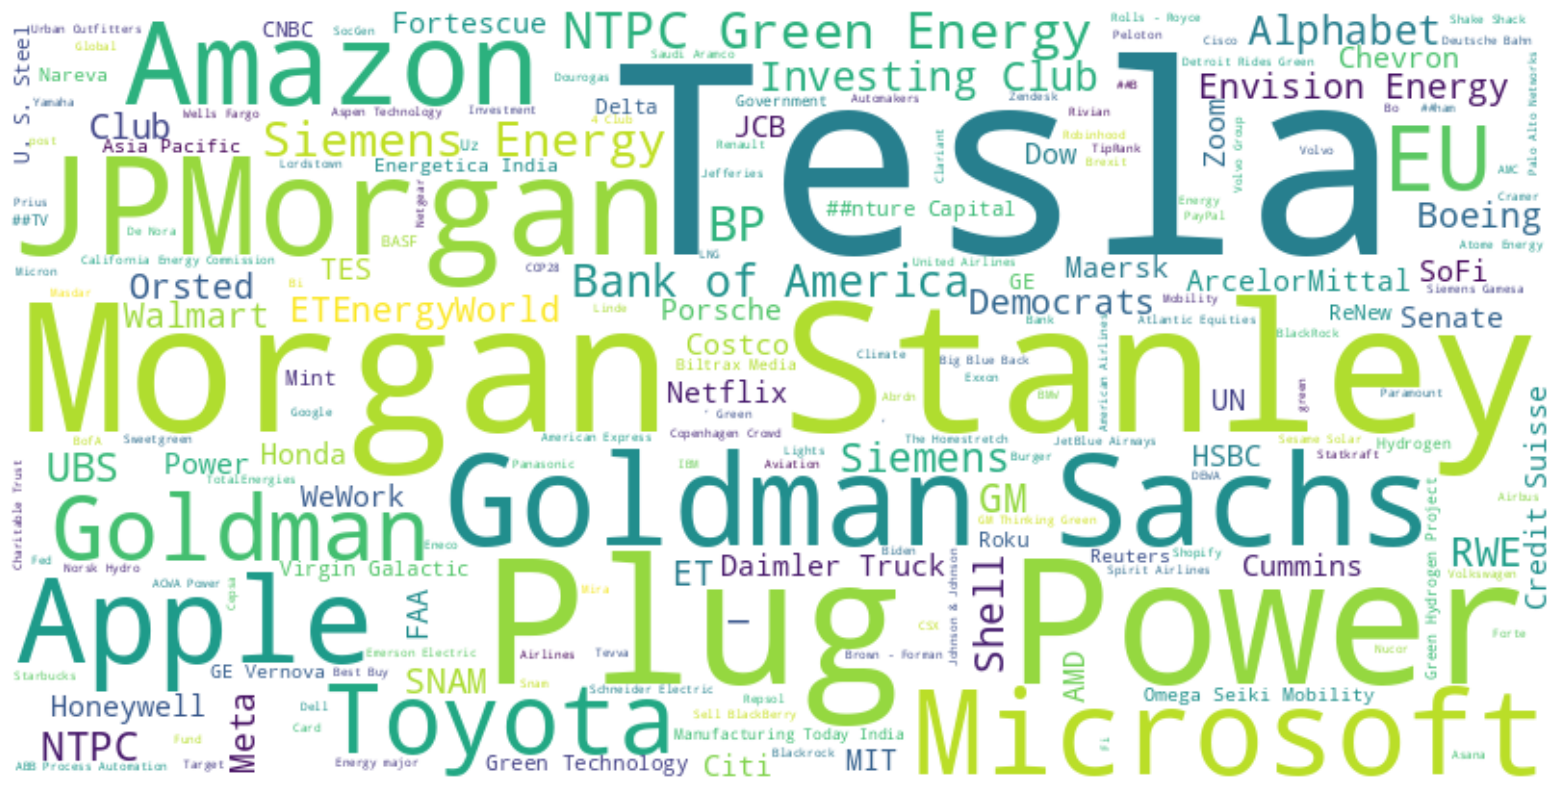

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

# Reshape array of arrays into a single array
org_list = list(chain(*organizations))

# Counting Frequencies of each organization
org_counts = Counter(org_list)

# Create a WordCloud object with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(org_counts)

# Display the WordCloud image using matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png', bbox_inches='tight')
plt.show()
plt.close()

#### Writing CSV to Google Sheets
Link - https://docs.google.com/spreadsheets/d/1PyEF5jmfWQWBs8XQ4Wp34f8UJhuRelPDWBpY2tbU8k4/edit#gid=1315432038


In [ ]:
#Uploading API Credentials
from google.colab import files
uploaded = files.upload()

import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ["https://spreadsheets.google.com/feeds", 'https://www.googleapis.com/auth/spreadsheets',
         "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/drive"]

credentials = ServiceAccountCredentials.from_json_keyfile_name('creds.json', scope)
client = gspread.authorize(credentials)

spreadsheet = client.open('GIS-Python')
#Saving dataframe to csv and then accessing it for writing to Google Sheets
df.to_csv('data.csv')
with open('data.csv', 'r') as file_obj:
    content = file_obj.read()
    client.import_csv(spreadsheet.id, data=content)

Saving creds.json to creds (2).json


#### Graph of Weekly average sentiment score

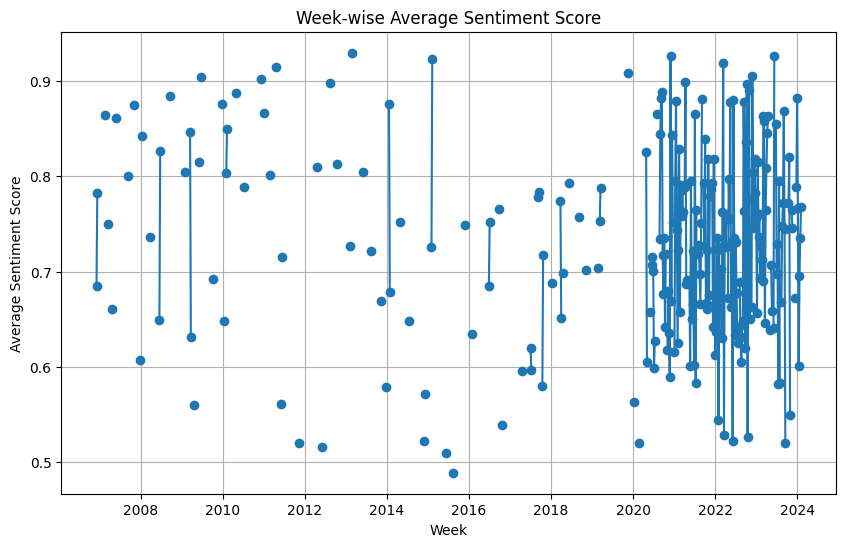

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame
newdf = df[['Date','Score']]

# Group by week and calculate the average sentiment score
weekly_avg = newdf.resample('W-Mon', on='Date').mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weekly_avg.index, weekly_avg['Score'], marker='o')
plt.title('Week-wise Average Sentiment Score')
plt.xlabel('Week')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.savefig('scoregraph.png', bbox_inches='tight')
plt.show()
plt.close()